In [7]:
from google.cloud import vision
from google.cloud.vision import types
import io
from PIL import Image, ImageDraw
from enum import Enum
import re
import string 
from aadhar import Validate

In [80]:
image_file='dl65.jpg'
image  = Image.open(image_file)

# Calling the API

In [81]:
client = vision.ImageAnnotatorClient()
with io.open(image_file, 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

In [82]:
print(document.text)

INDIAN UNION DRIVING LICENCE
ANDHRA PRADESH
AP70720170002521
GOPI NAIK G
RAVI NAIK
31-16-18
SULTANABAD
522202
TENALI
GUNTUR - 522202
G Cadirah
Signature
Issued On: 21/07/2017
Licencing Authority
UNIT OFFICE TENALI



# Plotting bounding boxes 

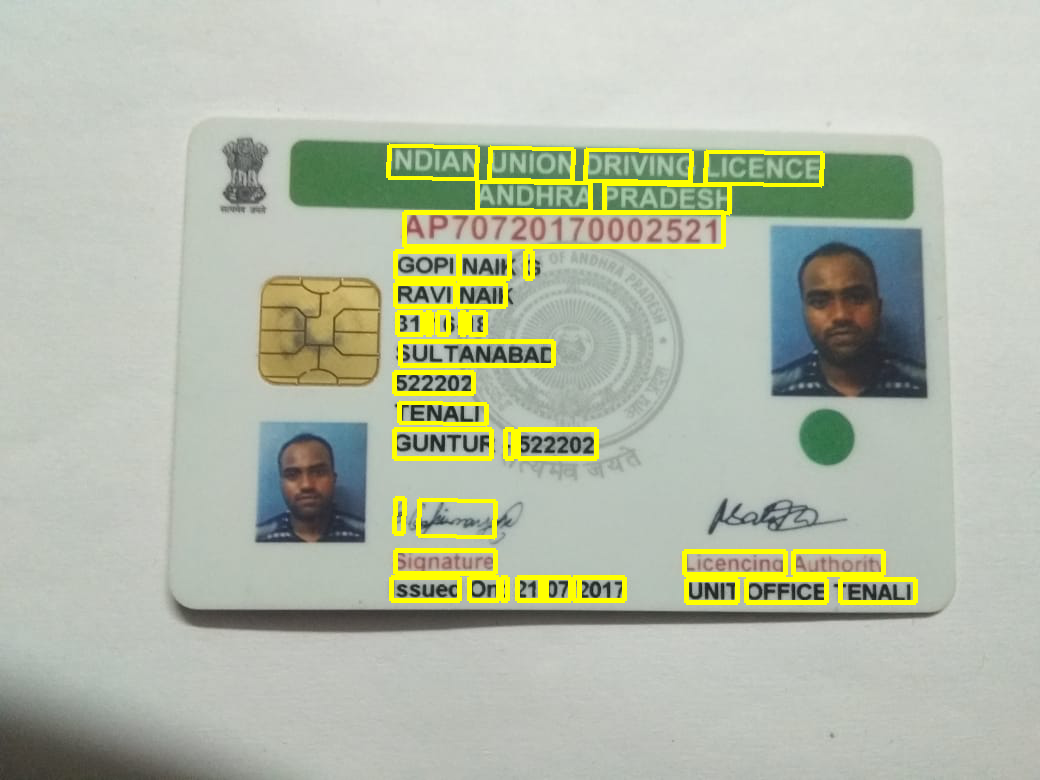

In [83]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5
    
def draw_boxes(image, bounds, color,width=5):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y],fill=color, width=width)
    return image

def get_document_bounds(response, feature):
    bounds=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature==FeatureType.BLOCK:
                bounds.append(block.bounding_box)
            for paragraph in block.paragraphs:
                if feature==FeatureType.PARA:
                    bounds.append(paragraph.bounding_box)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
    return bounds

bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'yellow')

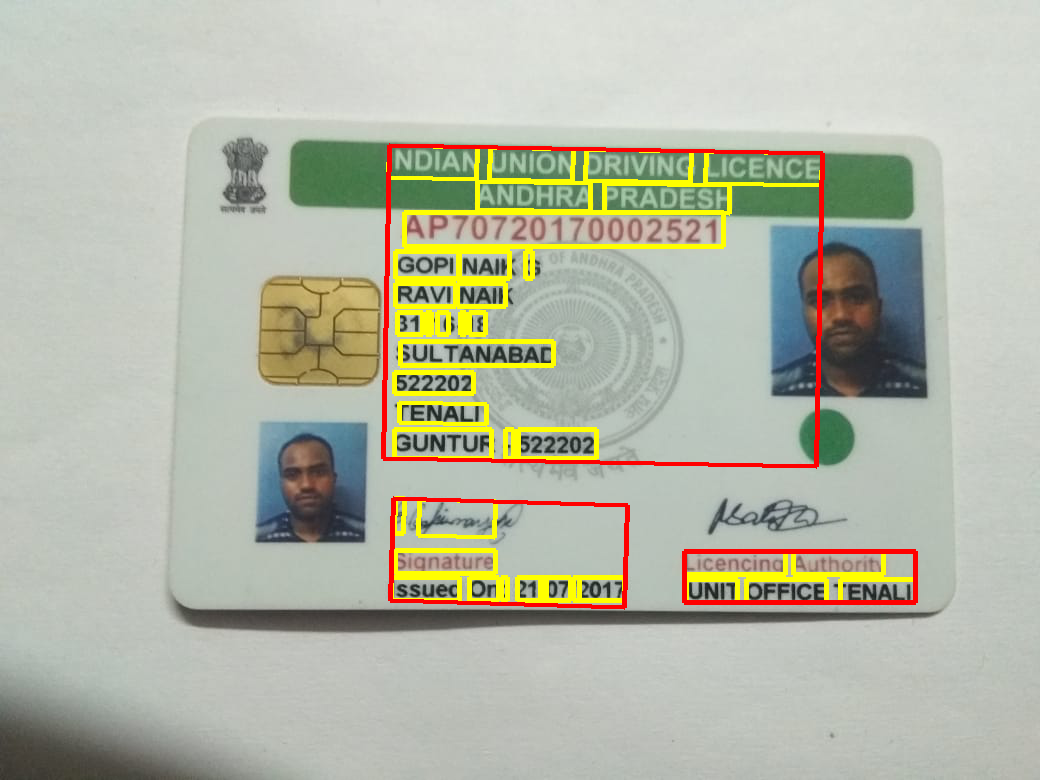

In [84]:
#FOR BLOCKS
bounds = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(image, bounds, 'red')

# Finding location of a word

In [85]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

def find_block_location(document,word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        return block.bounding_box

def find_word_location(document,word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        return word.bounding_box

                    
vision_client = vision.ImageAnnotatorClient()

with io.open(image_file, 'rb') as image_file2:
    content = image_file2.read()

content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation



In [86]:
pan_number = ""
aadhar_number = ""
dl_number = ""

stripped_document = re.sub('\n','',document.text)
stripped_document = re.sub(r'[^\x00-\x7f]',r'', stripped_document)
stripped_document = re.sub(r' ',r'',stripped_document)

pan_pattern = re.compile('[A-Z]{5}[0-9]{4}[A-Z]')
aadhar_pattern = re.compile('[0-9]{12}')
dl_pattern = re.compile('([A-Z]{2}(-){0,1}[0-9]{2}(19[0-9][0-9]|20[0,1][0-9])[0-9]{7})|([A-Z]{2}(-){0,1}[0-9]{3}(19[0-9][0-9]|20[0,1][0-9])[0-9]{7})')

pan_matcher = pan_pattern.findall(stripped_document)
aadhar_matcher = aadhar_pattern.findall(stripped_document)
dl_matcher = dl_pattern.search(stripped_document)

if(pan_matcher):
    pan_number = pan_matcher[0]
    print(pan_number)
if(aadhar_matcher):
    for x in aadhar_matcher:
        if(Validate(x)=='Valid Aadhar Number'):
            aadhar_number = x
if(dl_matcher):
    dl_number = dl_matcher.group(0)

print(dl_matcher)
print(stripped_document)

<re.Match object; span=(38, 54), match='AP70720170002521'>
INDIANUNIONDRIVINGLICENCEANDHRAPRADESHAP70720170002521GOPINAIKGRAVINAIK31-16-18SULTANABAD522202TENALIGUNTUR-522202GCadirahSignatureIssuedOn:21/07/2017LicencingAuthorityUNITOFFICETENALI


In [88]:
print(aadhar_number)
print(dl_number)
print(pan_number)


AP70720170002521



In [93]:
name = ""
location_name = find_block_location(document,'Name')
location_income = find_word_location(document,'INCOME')
location_india = find_word_location(document,'INDIA')
location_pan = find_word_location(document,pan_number)

location_aadhar = find_word_location(document,'Aadhaar')
location_govt = find_word_location(document,'GOVERNMENT')


if(pan_number):
    print("PAN CARD")
    #New Format of PAN CARD
    if(location_name):
        min_x = location_name.vertices[0].x
        min_y = location_name.vertices[0].y
        max_x = location_name.vertices[2].x
        max_y = location_name.vertices[2].y
        ls = text_within(document,min_x,min_y,max_x,max_y).split(" ")
        name = " ".join(ls[2:])
        print(name)
    else:
        min_x = location_income.vertices[0].x
        min_y = location_income.vertices[2].y+1
        max_x = location_india.vertices[0].x
        #max_y = (location_pan.vertices[0].y + location_income.vertices[2].y)/2
        max_y = location_income.vertices[2].y + 2 * (location_income.vertices[2].y - location_income.vertices[0].y )
        ls = text_within(document,min_x,min_y,max_x,max_y)
        print(ls)

if (aadhar_number):
    if(location_aadhar):
        min_x = location_aadhar.vertices[0].x - 3 * (location_aadhar.vertices[2].x-location_aadhar.vertices[0].x)
        min_y = location_aadhar.vertices[2].y
        max_x = location_aadhar.vertices[2].x
        max_y = location_aadhar.vertices[2].y + 2 * (location_aadhar.vertices[2].y - location_aadhar.vertices[0].y)
        ls = text_within(document,min_x,min_y,max_x,max_y)
        print(ls)
    if(location_govt):
        min_x = location_govt.vertices[0].x - (location_govt.vertices[2].x-location_govt.vertices[0].x)
        min_y = location_govt.vertices[2].y
        max_x = location_govt.vertices[2].x + (location_govt.vertices[2].x-location_govt.vertices[0].x)
        max_y = location_govt.vertices[2].y + 4 * (location_govt.vertices[2].y - location_govt.vertices[0].y)
        ls = text_within(document,min_x,min_y,max_x,max_y)
        ls = re.sub(r'[^\x00-\x7f]',r'', ls).split(" ")
        ln = " ".join([x for x in ls if x])
        name = ln
        print(name)

if (dl_number):
    location_dl_name = find_word_location(document,'Name')
    if(location_dl_name):
        min_x = location_dl_name.vertices[2].x + 2
        min_y = location_dl_name.vertices[0].y - (location_dl_name.vertices[2].y - location_dl_name.vertices[0].y)
        max_x = location_dl_name.vertices[2].x + 7 * (location_dl_name.vertices[2].x - location_dl_name.vertices[0].x)
        max_y = location_dl_name.vertices[2].y + (location_dl_name.vertices[2].y - location_dl_name.vertices[0].y)
        ls = text_within(document,min_x,min_y,max_x,max_y)
        name = ls
        print(name)
    if (dl_number[0:2]=='AP' or dl_number[0:2]=='TS'):
        location_dl = find_word_location(document,dl_number)
        min_x = location_dl.vertices[0].x - (location_dl.vertices[2].x-location_dl.vertices[0].x)
        min_y = location_dl.vertices[2].y
        max_x = location_dl.vertices[2].x - (location_dl.vertices[2].x-location_dl.vertices[0].x)/2
        max_y = location_dl.vertices[2].y + 1 * (location_dl.vertices[2].y - location_dl.vertices[0].y)
        ls = text_within(document,min_x,min_y,max_x,max_y)
        name = ls
        print(name)
    

GOPI NAIK G 


In [18]:
#FINDING TEXT WITHIN


def text_within(document,x1,y1,x2,y2): 
    text=""
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        min_x=min(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        max_x=max(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        min_y=min(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        max_y=max(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        if(min_x >= x1 and max_x <= x2 and min_y >= y1 and max_y <= y2):
                            text+=symbol.text
                            if(symbol.property.detected_break.type==1 or 
                               symbol.property.detected_break.type==3):
                                text+=' '
                            if(symbol.property.detected_break.type==2):
                                text+='\t'
                            if(symbol.property.detected_break.type==5):
                                text+='\n'
    return text

In [ ]:
from shapely.wkt import loads as load_wkt

def find_nearest 